In [1]:
""" Module for importing PraireView5.0+ generated .csv files."""
import os
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd
from lxml import etree

%matplotlib inline

In [ ]:
def _get_ephys_vals(element):
    ch_type = element.find('.//PatchclampChannel').text

    if ch_type == '0':
        unit = element.find('.//UnitName').text
        divisor = float(element.find('.//Divisor').text)

        return 'primary', {'unit': unit, 'divisor': divisor}

    elif ch_type == '1':
        unit = element.find('.//UnitName').text
        divisor = float(element.find('.//Divisor').text)

        return 'secondary', {'unit': unit, 'divisor': divisor}
    
    
def parse_xml(filename):
    tree = etree.parse(filename)
    # find all elements associated with enabled channels
    enabled_ch = tree.xpath('.//Enabled[text()="true"]')

    file_attr = {}
    ch_names = []
    for ch in enabled_ch:
        parent = ch.getparent()
        if parent.find('.//Type').text == 'Physical':
            clamp_device = parent.find('.//PatchclampDevice').text

            if clamp_device is not None:
                name, ephys_vals = _get_ephys_vals(parent)
                file_attr[name] = ephys_vals

            else:
                name = parent.find('.//Name').text

            ch_names.append(name.capitalize())

    file_attr['channels'] = ch_names
    # gets sampling rate
    file_attr['sampling'] = int((tree.find('.//Rate')).text)
    # gets recording time, converts to sec
    file_attr['duration'] = (int((tree.find('.//AcquisitionTime')).text))#/1000

    # finds the voltage recording csv file name
    datafile = (tree.find('.//DataFile')).text
    # finds the linescan profile file name (if doesn't exist, will be None)
    ls_file = (tree.find('.//AssociatedLinescanProfileFile')).text

    # If ls_file is none this could mean that there is no linescan associated
    # with that voltage recording file or that the file passed to parse_vr is
    # actually a LineScan data file and therefore should be passed to ls_file.
    # In that scenario there is no voltage recording file, so vo_file is None
    if ls_file is None:
        if "LineScan" in datafile:
            ls_file = datafile
            vo_file = None
        elif "LineScan" not in datafile:
            vo_file = datafile
    else:
        vo_file = datafile

    file_attr['voltage recording file'] = vo_file
    file_attr['linescan file'] = ls_file

    return file_attr

def import_vr_csv(filename, col_names, primary_div=1, secondary_div=1):
    """
    Reads voltage recording .csv file into a pandas dataframe.
    Will convert Primary and Secondary channels to appropriate values if those
    channels are in the file.
    Returns a dataframe
    """

    df = pd.read_csv(filename, names=col_names, skiprows=1)
    #df.Time /= 1000

    if "Primary" in df.columns:
        df.Primary /= primary_div
    if "Secondary" in df.columns:
        df.Secondary /= secondary_div

    return df


def import_ls_csv(filename):
    """Reads linescan profile .csv file into pandas dataframe.
    """

    #loads csv file into pandas dataframe
    df = pd.read_csv(filename, skipinitialspace=True)
    #renames column headers to remove "(ms)" from time headers
    df.rename(columns=lambda header: header.strip('(ms)'), inplace=True)
    #convert time from ms to sec by slicing every other column, since these are the time columns
    df.loc[:, ::2] /= 1000

    return df


def import_folder(folder):
    """Collapse entire data folder into multidimensional dataframe
    Returns a dictionary with "voltage recording", "linescan" and
    "file attributes" keys associate with 2 dataframes and a dictionary
    (respective).
    """
    vr_xmls = glob(os.path.join(folder, '*_VoltageRecording_*.xml'))

    if any(vr_xmls):
        data_vr = []
        data_ls = []
        sweep_list = []
        file_attr = {}
        output = {}

        for i, file in enumerate(vr_xmls):
            sweep = 'Sweep' + str(i+1).zfill(4)
            sweep_list.append(sweep)
            file_vals = parse_xml(file)

            if file_vals['voltage recording file'] is not None:
                vr_filename = os.path.join(folder,
                                           (file_vals['voltage recording file']
                                            + '.csv'))
                col_names = ['Time'] + file_vals['channels']
                primary_divisor = file_vals['primary']['divisor']
                #secondary_divisor = file_vals['secondary']['divisor']

                df_vr = import_vr_csv(vr_filename, col_names, primary_divisor,1)

                data_vr.append(df_vr)

            if file_vals['linescan file'] is not None:
                ls_filename = os.path.join(folder,
                                           (file_vals['linescan file']))

                df_ls = import_ls_csv(ls_filename)

                data_ls.append(df_ls)

            file_attr['File'+str(i+1)] = file_vals

        if data_vr:
            output["voltage recording"] = pd.concat(data_vr, keys=sweep_list,
                                                    names=['Sweep', 'Index'])
        elif not data_vr:
            output["voltage recording"] = None
        if data_ls:
            output["linescan"] = pd.concat(data_ls, keys=sweep_list,
                                           names=['Sweep', 'Index'])
        elif not data_ls:
            output["linescan"] = None
        output["file attributes"] = file_attr

    else:
        output = {"voltage recording": None, "linescan": None,
                  "file attributes": None}

    return output

def count_events(start, delta, threshold=0, up=True, trace=None, mark=True):
    """
    Counts the number of events (e.g action potentials (AP)) in the current trace.

    Arguments:

    start       -- starting time (in ms) to look for events.
    delta       -- time interval (in ms) to look for events.
    threshold   -- (optional) detection threshold (default = 0).
    up          -- (optional) True (default) will look for upward events, False downwards.
    trace       -- (optional) zero-based index of the trace in the current channel,
                   if None, the current trace is selected.
    mark        -- (optional) if True (default), set a mark at the point of threshold crossing
    Returns:
    An integer with the number of events.

    Examples:
    count_events(500,1000) returns the number of events found between t=500 ms and t=1500 ms
        above 0 in the current trace and shows a stf marker.
    count_events(500,1000,0,False,-10,i) returns the number of events found below -10 in the
        trace i and shows the corresponding stf markers.
    """

    # sets the current trace or the one given in trace.
    if trace is None:
        sweep = stf.get_trace_index()
    else:
        if type(trace) !=int:
            print ("trace argument admits only integers")
            return False
        sweep = trace

    # set the trace described in sweep
    stf.set_trace(sweep)

    # transform time into sampling points
    dt = stf.get_sampling_interval()

    pstart = int( round(start/dt) )
    pdelta = int( round(delta/dt) )

    # select the section of interest within the trace
    selection = stf.get_trace()[pstart:(pstart+pdelta)]

    # algorithm to detect events
    EventCounter,i = 0,0 # set counter and index to zero

    # choose comparator according to direction:
    if up:
        comp = lambda a, b: a > b
    else:
        comp = lambda a, b: a < b

    # run the loop
    while i<len(selection):
        if comp(selection[i],threshold):
            EventCounter +=1
            if mark:
                stf.set_marker(pstart+i, selection[i])
            while i<len(selection) and comp(selection[i],threshold):
                i+=1 # skip values if index in bounds AND until the value is below/above threshold again
        else:
            i+=1

    return EventCounter



#measure the numbers of action potentials evoked by current injections of -120pA to 300pA, in a list
def spike_list(x):
    spike_list = []
    for i in range(len(x)): 
        spike_number = count_events(x[i].Primary)
        spike_list.append(spike_number)
    return spike_list

#measure the rheobase current
def rheobaseCal(x):
    for i in range(len(x)):
        if spike_list(x)[i] >= 1: 
            rheobase = (i-5)*20
            break
    return rheobase

In [7]:
#measure resting membrane voltage Vm and membrane resistance Rm
def analyze_properties(df, bsl_start, bsl_end, start_time, end_time):
    if df is not None:
        data = df.copy()
        Vm = data.Primary[(data.Time >= bsl_start) &
                              (data.Time <= bsl_end)].mean()
        V_ss = data.Primary[(data.Time >= start_time) &
                              (data.Time <= end_time)].mean()

        Rm = (V_ss-Vm)/-0.02
        result_list = [Vm, Rm]
    return result_list

In [8]:
#import voltage recording traces in response to current injection steps (from -120 pA, 20 pA increments)
vr_folders = glob(os.path.join('/Users/shenyuzhai/Desktop/In_progress 2/', 'cell1-***'))
vr_folders = sorted(vr_folders)
df_vr_list = []
trace_list = []
for i, folder in enumerate(vr_folders):
        #col_names = ['Time'] + ['Primary']
        df_vr = import_folder(vr_folders[i])['voltage recording']
        df_vr_list.append(df_vr)
        trace = 'celli-' + str(i+1).zfill(3)
        trace_list.append(trace)
        #aligneddata = pd.concat(df_vr_list, keys=trace_list)

len(df_vr_list)  #to check the number of sweeps imported


26

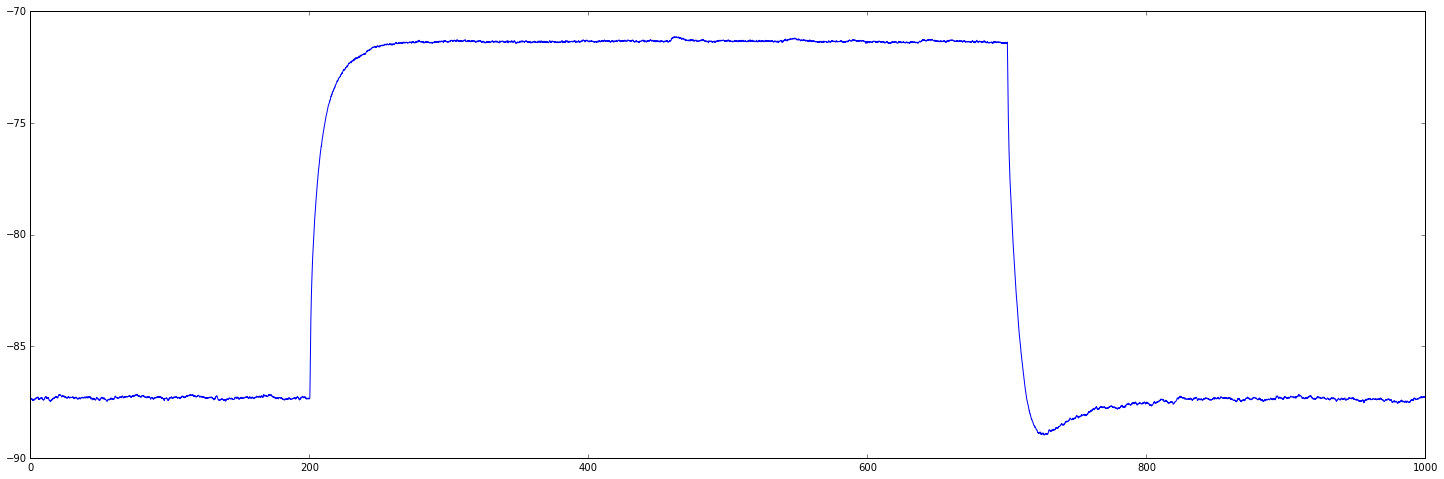

In [10]:
#plot one sweep
plt.figure(figsize=(25,8)) 
plt.plot(df_vr_list[(len(df_vr_list)-2)].Time, df_vr_list[13].Primary)

In [11]:
#measurement number of evoked action potentials in each sweep
result2 = spike_list(df_vr_list)


TypeError: count_events() missing 1 required positional argument: 'delta'

In [ ]:
#measure the rheobase
rheobaseCal(df_vr_list)

In [ ]:
#measure Vm and Rm using -20pA injection trace; set measurement windows after visual inspection of the trace above; 
#append rheobase measurement
result1 = analyze_properties(df_vr_list[5], 5, 195, 300, 400)
result1.append(rheobaseCal(df_vr_list))
print (result1)

In [ ]:
#Create a list of injected currents
Injection_number = len(df_vr_list)
current_list = []
for i in range(6):
    current = -120-(i*-20)
    current_list.append(current)
for i in range(7,(Injection_number+1)):
    current = -120-(i*-20)
    current_list.append(current)
print (current_list[-1])

In [ ]:
#plot the current-response curve
plt.plot(current_list, result2, 'o', color='black');
#plt.ylim(-2, 20)
plt.xlim(0,current_list[-1])

In [ ]:
#this is the current-response result
pd.DataFrame(result2, index = current_list)

In [ ]:
#this is the Vm, Rm, and Rheobase data
pd.DataFrame(result1, index = ['Vm', 'Rm', 'Rheobase'])